#### Setting

In [4]:
from gnews import GNews

import pandas as pd

from datetime import date, timedelta

import os
import re
import ast

import warnings
warnings.filterwarnings(action='ignore')

#### Crawler

In [5]:
google_news = GNews(language='en', country='US', period='1d')

start_date = date(2020, 1, 1)
end_date = date(2020, 1, 2)

news_info = []
empty_list = [] # 뉴스가 하나도 없는 날짜

excel_file = f'news_data_{start_date.year}_{start_date.month}.xlsx'
current_month = start_date.month

while start_date <= end_date:
    google_news.start_date = start_date
    google_news.end_date = start_date + timedelta(days=1)  # Set end date as the next day of start date
    
    news = google_news.get_news('tesla')
    
    print(f"크롤링 중인 날짜: {start_date}:", start_date,'해당 날짜에 뉴스 갯수',len(news))

    if len(news) == 0:  # 뉴스가 하나도 없는 날
        empty_list.append(start_date)

    for article in news:
        news_info.append([article['publisher'], article['published date'], article['title'], article['description']])

    # 달이 변경되면 
    if start_date.month != current_month:
        df = pd.DataFrame(news_info, columns=['Publisher', 'Date', 'Title', 'Description'])
        df.to_excel(excel_file, index=False)
        
        news_info = []  # 리스트를 초기화합니다.
        current_month = start_date.month
        excel_file = f'news_data_{start_date.year}_{start_date.month}.xlsx'  # 새로운 엑셀 파일 이름을 설정합니다.

    start_date += timedelta(days=1)  # Increment start date by one day

crawler_df = pd.DataFrame(news_info, columns=['Publisher', 'Date', 'Title', 'Description'])
crawler_df.to_excel(excel_file, index=False)

print("뉴스가 하나도 없는 날 : ", empty_list)

크롤링 중인 날짜: 2020-01-01: 2020-01-01 해당 날짜에 뉴스 갯수 8
크롤링 중인 날짜: 2020-01-02: 2020-01-02 해당 날짜에 뉴스 갯수 18
뉴스가 하나도 없는 날 :  []


In [7]:
# 크롤링 데이터 형식
crawler_df.head()

,Publisher,Date,Title,Description
0,"{'href': 'https://www.theguardian.com', 'title...","Thu, 02 Jan 2020 08:00:00 GMT",Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...
1,"{'href': 'https://jalopnik.com', 'title': 'Jal...","Wed, 01 Jan 2020 08:00:00 GMT",Tesla's Decade Of Survival - Jalopnik,Tesla's Decade Of Survival Jalopnik
2,"{'href': 'https://news.yahoo.com', 'title': 'Y...","Wed, 01 Jan 2020 08:00:00 GMT",Cyberquad ATV Add-On Sweetens Appeal of Tesla’...,Cyberquad ATV Add-On Sweetens Appeal of Tesla’...
3,"{'href': 'https://carbuzz.com', 'title': 'CarB...","Wed, 01 Jan 2020 08:00:00 GMT",Tesla Cybertruck Makes Music Video Debut - Car...,Tesla Cybertruck Makes Music Video Debut CarBuzz
4,"{'href': 'https://carbuzz.com', 'title': 'CarB...","Wed, 01 Jan 2020 08:00:00 GMT",All-New Tesla Model S Could Look Like This - C...,All-New Tesla Model S Could Look Like This Ca...


#### Data Transformation

In [10]:
# 데이터가 있는 디렉토리
data_dir = "C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly"
output_dir = "C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

entire_dataset = pd.DataFrame()
raw_df = pd.DataFrame()

for filename in sorted(os.listdir(data_dir)):
    file_path = os.path.join(data_dir, filename)
    
    if not filename.endswith('.xlsx'):
        continue

    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.strftime('%Y.%m.%d')

    # 'Publisher' 컬럼의 'title' 값만 추출
    df['Publisher'] = df['Publisher'].apply(lambda x: ast.literal_eval(x)['title'] if pd.notnull(x) else x)

    # 'Title' 컬럼에서 'Publisher' 값을 제거
    df['Title'] = df.apply(lambda row: row['Title'].replace(row['Publisher'], '').strip(), axis=1)

    # 'Description' 컬럼에서 'Publisher' 값을 제거
    df['Description'] = df.apply(lambda row: row['Description'].replace(row['Publisher'], '').strip() if pd.notnull(row['Description']) else row['Description'], axis=1)

    # 'Description' 컬럼의 값에서 영어가 아닌 문자 제거
    df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

    # 'Description' 컬럼의 값에서 영어가 아닌 한자, 한국어, 일본어 등 제거
    df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
    
    raw_df = raw_df._append(df, ignore_index=True)
    
    # 'Date' 컬럼으로 그룹화하고 'Publisher'와 'Description' 컬럼을 각각 합침
    df_consolidated = df.groupby(['Date']).agg({'Publisher': ' '.join, 'Description': ' '.join}).reset_index()

    # 그룹의 크기를 나타내는 'News_Count'라는 열을 추가
    df_consolidated['News_Count'] = df.groupby(['Date']).size().values

    # 모든 데이터를 저장하는 데이터프레임에 추가
    entire_dataset = entire_dataset._append(df_consolidated, ignore_index=True)

# 'Date' 컬럼을 datetime 형식으로 변환
entire_dataset['Date'] = pd.to_datetime(entire_dataset['Date'])

# 날짜에서 요일을 추출 (월요일: 0, 일요일: 6)
entire_dataset['weekday'] = entire_dataset['Date'].dt.weekday

# 요일이 토요일(5), 일요일(6)인 경우 그 다음 월요일로 변경한 날짜를 'group_date'라는 새로운 컬럼에 저장
entire_dataset['group_date'] = entire_dataset.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)

# 'group_date' 컬럼의 이름을 'Date'로 변경
entire_dataset.rename(columns={'group_date': 'new_date'}, inplace=True)

# 'Date' 컬럼으로 그룹화하여 'Publisher', 'Description', 'News_Count' 컬럼의 값들을 합침
news_df = entire_dataset.groupby(['new_date']).agg({'Publisher': ' '.join, 'Description': ' '.join, 'News_Count': 'sum'}).reset_index()
news_df = news_df.sort_values(by=["new_date"], ascending=[True]) 
news_df = news_df[news_df['new_date'] <= '2022-12-31']

def str_to_list(char):
    return list(set(list(char.split(" "))))
    
news_df['Publisher'] = news_df['Publisher'].apply(str_to_list)
news_df.head()

,new_date,Publisher,Description,News_Count
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27


In [12]:
news_df

,new_date,Publisher,Description,News_Count
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27
...,...,...,...,...
778,2022-12-26,"[Car, Drive, Fox, Motor16, Motley, Washington,...",Elon Musks Twitter obsession isnt the core rea...,24
779,2022-12-27,"[TIME, Inverse, Tampa, Telex, ADAC, Lrytas.lt,...",Why Tesla Stocks Dropped So Much in 2022 Tesla...,14
780,2022-12-28,"[Sky, Interview, Du, Yahoo, News, E24, USA, Fi...",Bus und Bahn in Oberhavel Weniger Zulassungen ...,18
781,2022-12-29,"[Torque, Drive, Yahoo, Electrek, News, Mashabl...",Musk tells Tesla workers not to be bothered by...,20


In [13]:
# 나중에 감성 분석을 위해
raw_df

,Publisher,Date,Title,Description
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...
...,...,...,...,...
17781,Torque News,2022.10.01,What A Tesla Model 3 Could Mean For You -,What A Tesla Model 3 Could Mean For You
17782,Hindustan Times,2022.10.02,Want to work for Tesla? Elon Musk tweets askin...,Want to work for Tesla Elon Musk tweets asking...
17783,CNN en Español,2022.10.01,El robot de Tesla caminó lentamente sobre el e...,El robot de Tesla camin lentamente sobre el es...
17784,TheStreet,2022.10.01,New Electric Vehicle Beats Tesla When it Comes...,New Electric Vehicle Beats Tesla When it Comes...


In [22]:
raw_df.to_csv(os.path.join(output_dir, "crawling_dataset.csv"), index=False)
news_df.to_csv(os.path.join(output_dir, "transformation_dataset.csv"), index=False)

#### Data Preprocessing

#### Setting

In [15]:
# 분석에 사용할 Dataframe
tsla_news_df = news_df.copy()
tsla_news_df.rename(columns={'new_date':'Date'}, inplace = True)
tsla_news_df.head()

,Date,Publisher,Description,News_Count
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27


In [16]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import spacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

nlp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords_default = stopwords.words('english')
custom_stop_words = set(ENGLISH_STOP_WORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
# 추가적인 불용어 카테고리별로 설정
general_stopwords = ['with', 'was', 'will', 'why', 'what', 'you', 'your', 'who', 'yet', 'years', 'world', 'working', 'work', 'we', 'when']
date_stopwords = ['january', 'fabruary', 'march','april','may','june','july','agust','september','october','november','december']
other_stopwords = ['do']

all_additional_stopwords = general_stopwords +date_stopwords + other_stopwords

for stopword in all_additional_stopwords:
    stopwords_default.append(stopword)

# 전처리 : 표제어 + 불용어 적용 안되는 것
noun_words = ['beans', 'murphy','rockets',
              'producevehicle','games','airlines','operators','facilities',
              'videos','claims','masks','nations','vehicles','ploblems','photos',
              'sits','relations','covers','hands','tensions','capabilities','nations','requests','endorsements',
              'teams', 'ploblems','areas','streets','signs','possiblities','workers','sales','adopters','developments',
              'companies','clubs','dashboards','powerwalls','panalties','challenges','tasks','machines','households',
              'negotiations','politics','overseas','homeowners','wars','movies','autospies','paneles','withdraws',
              'margins','automakers','nuevos','flaws','deepfakes','believers','angeles','spacers','deliveries','fails']
verb_words = ['have','waived','involving','abundoning','contribute','engaged','recalled','intensifying','led','curves',
              'received', 'charges', 'investigating', 'intensifying', 'said','retreating','considering','remains','began','displayed',
              'fired','lined','depanding','blamed','killing','sitting','opted','enticing','reviewing','contends','missed','balancing',
              'anticipated','jumped','delievered','shifted','killed','concerning','arrived','defects','argued','disclosed',
              'explained','appears','stopped','depending','battered','thinking','pressured','slowing','tumbling','tensifying',
              'explained','restarts','admitted','demands','totaled','demonstrates','opposing','interested','acting','taken','braking',
              'peaking','dethroned','met','guessed','developer','outstanding','performing','loaded','rides','launched','allows',
              'thrilled','operated','refusing','slumped','affected','appeared','removing','saying','related','troubled',
              'advanced','raised','killed','defects','crewed','performing','leaving','got','explains','raising',
              'inspires','injured','sales','powered','pulled','cutting','fleeing','creating','growing','coming',
              'leasing','promising','revealed','nailed','did','linking','tuned','optimizes','badged',
              'receives','patched','encourageing','thought','recommends','combined','endangered','counterfeiting',
              'challenging','owned','missing','creates','closing','won','hinting','billing','rolling','nears','breaking','given',
              'commemorating','receiving','going','targeted','kicking','replaced','seeking','promotes','taking',
              'stealing','spotted','celebrating','extended','preserving','allows','cutting','including','positioning',
              'extends','enabled','fixing','replacing','promotes','sends','flying','replanting','responds','rumoured',
              'installed','inspired','isolating','designed','earnings','jolted','adding','picking','running','rolls',
              'acquires','electrifying','sustaining','redesigned','committed','branded','launched','prepares','worked',
              'zoomed','shares','earnings','confirmed','making', 'makes','abandoning','abandoned','abandons','delievering',
              'replaces','sent','says']
adject_words = ['nearest','safer','older','worse','slower','lower','hottest','coolest','effectively','originally','cheaper']

In [19]:
# preprocessing function : 소문자화, 영어만 적용, Stemming, Lemmatization, token 화 사용함

def preprocess_sentence(sentence):
    # 소문자화와 영어 단어 추출
    sentence = sentence.lower()
    words = re.findall(r'\b[a-z]+\b', sentence)

    # Spacy를 사용하여 텍스트를 처리합니다.
    doc = nlp(' '.join([word for word in words if word not in stopwords_default]))

    # 불용어를 제거하고, 각 토큰을 원형으로 변환합니다.
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
      ## 표제어 추출
    # noun_words의 단어를 명사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='n') if word in noun_words else word for word in tokens]
    # verb_words의 단어를 동사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='v') if word in verb_words else word for word in tokens]
    # adject_words의  단어를 형용사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='a') if word in adject_words else word for word in tokens]
    
    tokens = list(set(tokens))
    tokens = [token for token in tokens if len(token)>2]

    return ' '.join(tokens)

In [20]:
tsla_news_df['corpus'] = tsla_news_df['Description'].apply(preprocess_sentence)
tsla_news_df.head()

,Date,Publisher,Description,News_Count,corpus
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,tesla like debut music video supercharger mode...
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21,uit goldsboro man car des customer stock nye s...
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27,dulle home ble man car gran stock fourth tempe...
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45,die bicyclist probe business reim display cutt...
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27,gigafactora month offiziell har program swing ...


In [27]:
# 원본 데이터에도 전처리 진행 후 결과 확인하기
raw_df['corpus'] = raw_df['Description'].apply(preprocess_sentence)
raw_df.head()

,Publisher,Date,Title,Description,corpus
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,tesla crash california autopilot kill
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,tesla cybertruck debut music make video
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,tesla like model allnew look
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,tesla office set israel
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,tesla map supercharger new update location


In [21]:
tsla_news_df.to_csv(os.path.join(output_dir, "preprocessed_data.csv"), index=False)

#### Text Vectorization(Using TF-IDF)

#### Setting

In [23]:
import numpy as np

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
%matplotlib inline

from PIL import Image

from sklearn.decomposition import PCA, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, normalize

#### word -featuring : 분석에 사용할 키워드 갯수 정하기, 뉴스에서 사용할 최소한의 키워드

#### 설명 : 뉴스에서 나온 모든 데이터 셋을 사용하기에는 비용, 시간 측면에서 무리일 수 있어서, 중요한 키워드를 TF-IDF 값을 기준으로 식별해보기

#### 그럼 이 때 TF-IDF 값 기준으로 식별을 하는데, 날 마다 몇개의 키워드를 선택해야하나 라는 의문 발생, 아래 지표는 해당 갯수 측정을 위함

In [39]:
# 뉴스 데이터 가져오기
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(tsla_news_df['corpus'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# 단어 목록을 행으로 하는 tfidf 행렬
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.shape

(783, 17454)

In [40]:
# visualization function
def plot_keywords(x, y, y_label, title):

    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10,6))

    plt.plot(x, y,  marker='o', color = 'b')

    plt.gca().invert_xaxis()

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().set_facecolor('lightgray')
    plt.grid(color='white', linestyle='-', linewidth=1)

    k_formatter = FuncFormatter(lambda x, pos: f'K{x}')
    plt.gca().xaxis.set_major_formatter(k_formatter)

    plt.xticks(range(min(keyword_counts), max(keyword_counts)+1))

    plt.xlabel('Number of selected top keywords from each data')
    plt.ylabel(y_label)

    # for i in [3, 4, 5]:
    #     if i in x:
    #         index = x.index(i)
    #         plt.plot(i, y[index], marker='o', color='y')

    plt.title(title)
    plt.show()

keyword_counts = list(range(20, 1, -1))
tfidf_matrix_transposed = tfidf_matrix.toarray()

#### Metric 1 : Mean of the TF-IDF scores of a word-feature across data

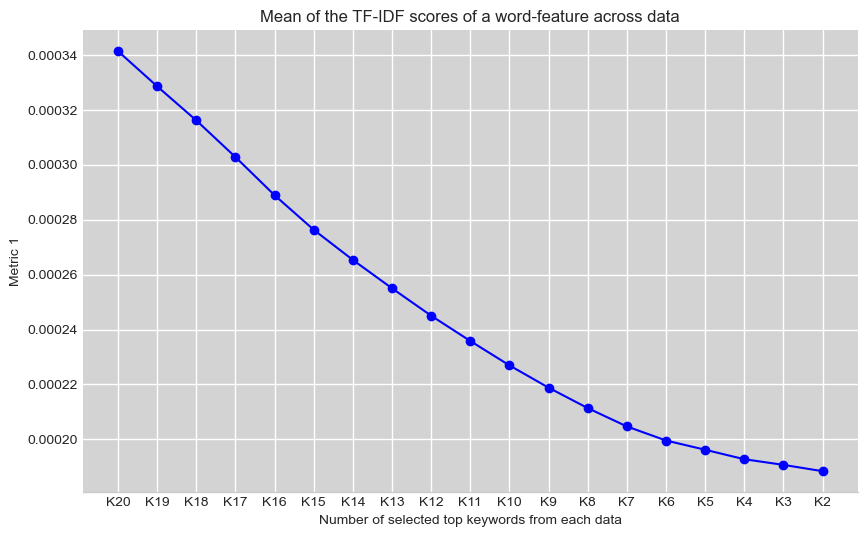

In [41]:
mean_tfidf_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])
    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_tfidf_scores = tfidf_matrix[:, keyword_indices].toarray()

    # TF-IDF score 평균 계산
    mean_tfidf_score = np.mean(keyword_tfidf_scores)
    mean_tfidf_scores.append(mean_tfidf_score)

plot_keywords(keyword_counts, mean_tfidf_scores, 'Metric 1',  'Mean of the TF-IDF scores of a word-feature across data')

#### Metric 2 : Mean of the cosine similarities of a word-feature to other features


C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


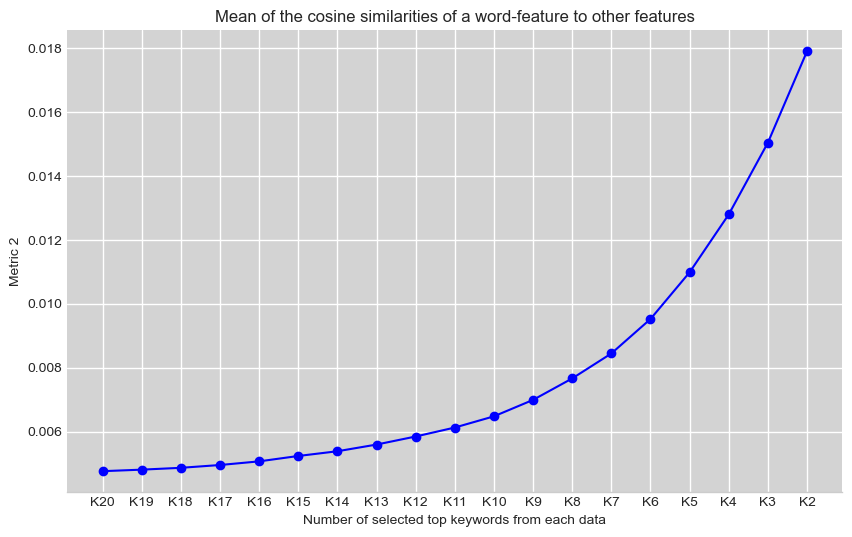

In [28]:
mean_cosine_similarities = []

for num_keywords in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-num_keywords:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices].T
    cosine_similarities = cosine_similarity(keyword_matrix)

    mean_cosine_similarity = np.mean(cosine_similarities)
    mean_cosine_similarities.append(mean_cosine_similarity)

plot_keywords(keyword_counts, mean_cosine_similarities,'Metric 2', 'Mean of the cosine similarities of a word-feature to other features')

#### Metric 3 : Cosine similarity between a word-feature and the centroid of features

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


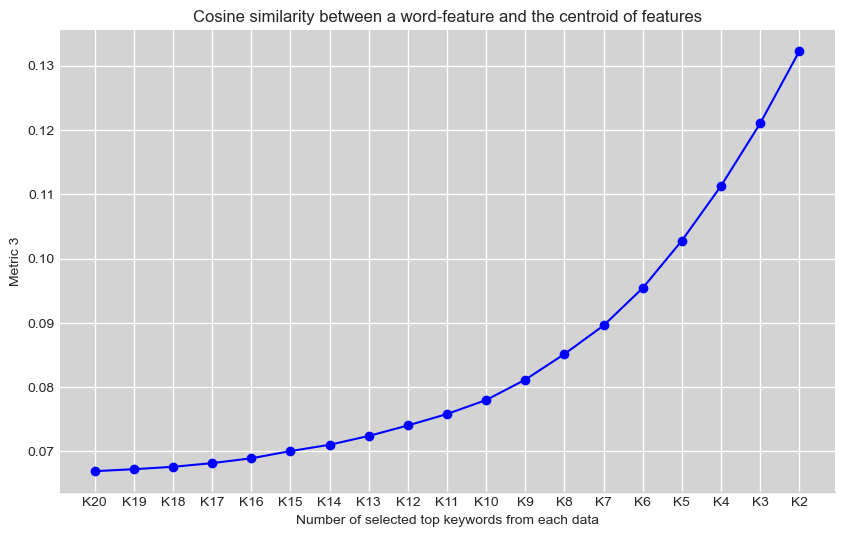

In [29]:
median_cosine_similarities = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices]

    keyword_matrix = keyword_matrix.T.toarray()

    centroid = np.mean(keyword_matrix, axis=0)
    centroid = np.asarray(centroid).reshape(1, -1)

    cosine_similarities = []

    for idx in range(keyword_matrix.shape[0]):
        word_vector = keyword_matrix[idx, :]
        word_vector = np.asarray(word_vector).reshape(1, -1)
        cosine_similarity_value = cosine_similarity(word_vector, centroid)
        cosine_similarities.append(cosine_similarity_value[0][0])


    mean_cosine_similarity = np.mean(cosine_similarities)
    median_cosine_similarities.append(mean_cosine_similarity)

plot_keywords(keyword_counts, median_cosine_similarities, "Metric 3", "Cosine similarity between a word-feature and the centroid of features")

#### Metric 4 : Mean of the dot product scores of a word-feature to other features

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


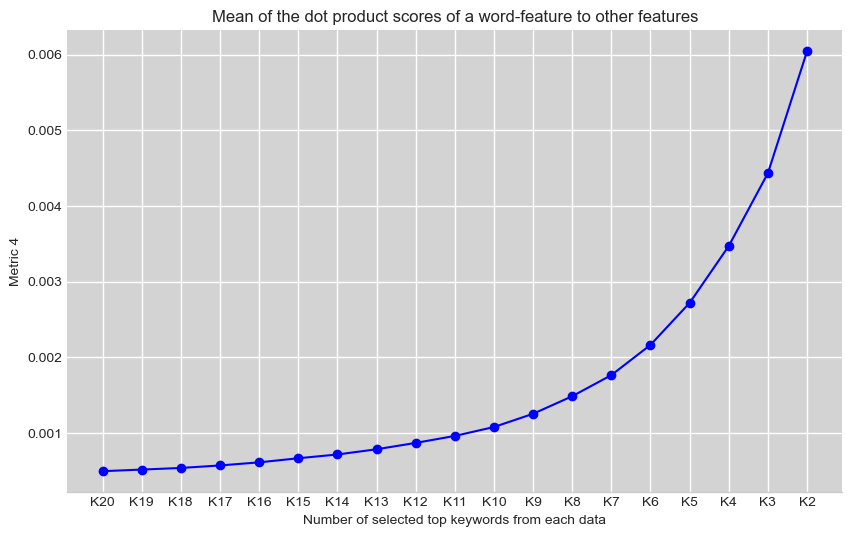

In [30]:
mean_dot_product_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_tfidf_scores = tfidf_matrix[:, keyword_indices].toarray()
    dot_product_scores = np.dot(keyword_tfidf_scores.T, keyword_tfidf_scores)

    mean_dot_product_score = np.mean(dot_product_scores)
    mean_dot_product_scores.append(mean_dot_product_score)

plot_keywords(keyword_counts, mean_dot_product_scores,"Metric 4", "Mean of the dot product scores of a word-feature to other features")

#### Metric 5 : LDA score of a word-feature for the single topic of entire data set

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


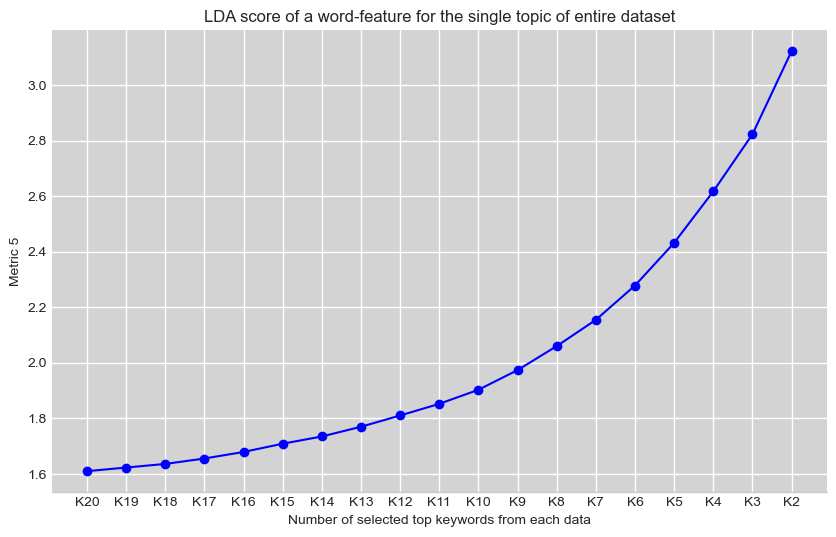

In [31]:
mean_lda_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))
    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices].toarray()

    num_topics = 1
    lda_model = LatentDirichletAllocation(n_components=num_topics)
    lda_model.fit(keyword_matrix)

    lda_scores = lda_model.components_

    mean_lda_score = np.mean(lda_scores)
    mean_lda_scores.append(mean_lda_score)

plot_keywords(keyword_counts, mean_lda_scores,"Metric 5", "LDA score of a word-feature for the single topic of entire dataset")

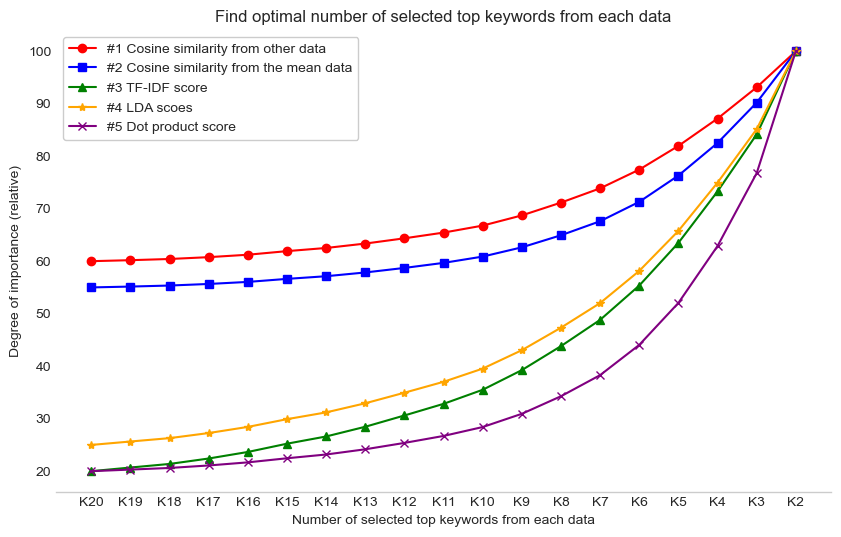

In [35]:
metric1_values = median_cosine_similarities
metric2_values = mean_cosine_similarities
metric3_values = mean_tfidf_scores
metric4_values = mean_lda_scores
metric5_values = mean_dot_product_scores

metric1_normalized = (metric1_values - np.min(metric1_values)) / (np.max(metric1_values) - np.min(metric1_values)) * 40 + 60
metric2_normalized = (metric2_values - np.min(metric2_values)) / (np.max(metric2_values) - np.min(metric2_values)) * 45 + 55
metric3_normalized = (metric3_values - np.min(metric3_values)) / (np.max(metric3_values) - np.min(metric3_values)) * 80 + 20
metric4_normalized = (metric4_values - np.min(metric4_values)) / (np.max(metric4_values) - np.min(metric4_values)) * 75 + 25
metric5_normalized = (metric5_values - np.min(metric5_values)) / (np.max(metric5_values) - np.min(metric5_values)) * 80 + 20

# plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))

plt.gca().invert_xaxis()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.gca().set_facecolor('lightgray')

plt.xticks(range(min(keyword_counts), max(keyword_counts)+1))

k_formatter = FuncFormatter(lambda x, pos: f'K{x}')

plt.gca().xaxis.set_major_formatter(k_formatter)
plt.grid(color='white', linestyle='-', linewidth=1)
plt.xlabel('Number of selected top keywords from each data')
plt.ylabel('Degree of importance (relative)')

plt.plot(keyword_counts, metric1_normalized, marker='o', label='#1 Cosine similarity from other data', color='red')
plt.plot(keyword_counts, metric2_normalized, marker='s', label='#2 Cosine similarity from the mean data', color='blue')
plt.plot(keyword_counts, metric3_normalized, marker='^', label='#3 TF-IDF score', color='green')
plt.plot(keyword_counts, metric4_normalized, marker='*', label='#4 LDA scoes', color='orange')
plt.plot(keyword_counts, metric5_normalized, marker='x', label='#5 Dot product score', color='purple')

plt.xlabel('Number of selected top keywords from each data')
plt.ylabel('Degree of importance (relative)')
plt.title('Find optimal number of selected top keywords from each data')
plt.legend(frameon = True, framealpha=1)

plt.show()

#### 최종 결론으로 날마다 최소한의 키워드 갯수만 사용하기 위함

In [43]:
all_keywords = []
top_keywords_per_document = []
feature_names = tfidf_vectorizer.get_feature_names_out()

for i in range(len(df)):
    tfidf_scores = zip(feature_names, tfidf_matrix[i].toarray()[0])
    sorted_tfidf_scores = sorted(tfidf_scores,key=lambda x: x[1], reverse=True)

    top_keywords_per_document.append([keyword for keyword,_ in sorted_tfidf_scores[:7]])

all_keywords=[keyword for document in top_keywords_per_document for keyword in document]

vectorizer = TfidfVectorizer(vocabulary=list(set(all_keywords)))
tfidf_matrix = vectorizer.fit_transform(tsla_news_df['corpus'])

print("현재 News 갯수:",tfidf_matrix.shape[0])
print("현재 word-feature 갯수:",tfidf_matrix.shape[1])

현재 News 갯수: 783
현재 word-feature 갯수: 3320


In [45]:
raw_df.head()

,Publisher,Date,Title,Description,corpus
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,tesla crash california autopilot kill
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,tesla cybertruck debut music make video
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,tesla like model allnew look
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,tesla office set israel
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,tesla map supercharger new update location


#### 설명 : 위의 과정까지가 원본 텍스트 데이터에서 전처리 및 핵심 키워드 추출 등을 거쳐서 벡터화까지 진행한 형태

####  Description analysis : 가공된 데이터를 바탕으로 정보 추출

In [46]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=list(set(all_keywords)))
average_tfidf = tfidf_df.mean()
average_tfidf_dict = average_tfidf.to_dict()

#### 날짜별 중요 키워드(TF-IDF 기반)으로 추출

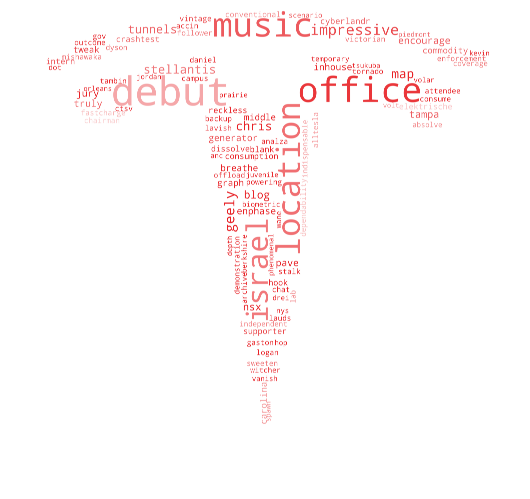

In [47]:
# 워드 클라우드 생성 함수 : Tesla News 들의 Word clound, Tesla logo 모양을 바탕으로 진행, 상위 100개만 표시함

mask = np.array(Image.open("C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/tesla_logo.jpg"))

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=list(set(all_keywords)))
average_tfidf = tfidf_df.mean()
average_tfidf_dict = average_tfidf.to_dict()

# 워드 클라우드 생성
image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(background_color="white",
                      mode="RGBA",
                      mask = mask,
                      width=800, 
                      height=800,
                      scale=2,
                      max_words=100).generate_from_frequencies(average_tfidf_dict)

image_colors = ImageColorGenerator(mask)

plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("wordcloud.png", dpi=300)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="antialiased")

#### 전체 데이터셋의 단순 빈도수 기반 Word Cloud

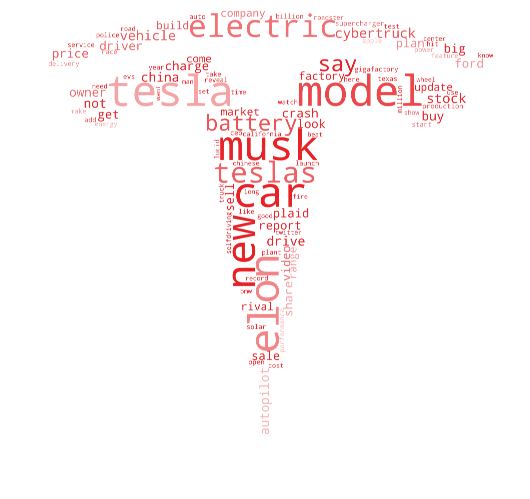

In [49]:
# 워드 클라우드 생성 함수 : Tesla News 들의 Word clound, Tesla logo 모양을 바탕으로 진행, 상위 100개만 표시함

mask = np.array(Image.open("C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/tesla_logo.jpg"))

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tsla_news_df['corpus'])

word_freq = np.sum(tfidf_matrix.toarray(), axis=0)
word_freq_dict = dict(zip(vectorizer.get_feature_names_out(), word_freq))

image_colors = ImageColorGenerator(mask)

# 워드 클라우드 생성
wordcloud = WordCloud(background_color="white",
                      mode="RGBA",
                      mask = mask,
                      width=800, 
                      height=800,
                      scale=2,
                      max_words=100).generate_from_frequencies(word_freq_dict)

image_colors = ImageColorGenerator(mask)

plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("wordcloud.png", dpi=300)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="antialiased")

#### 위의 과정은 날짜별로 진행, 이번에는 원본 데이터 셋 날짜별로 합치기 전에 빈도 수 기반으로 그려보겠음

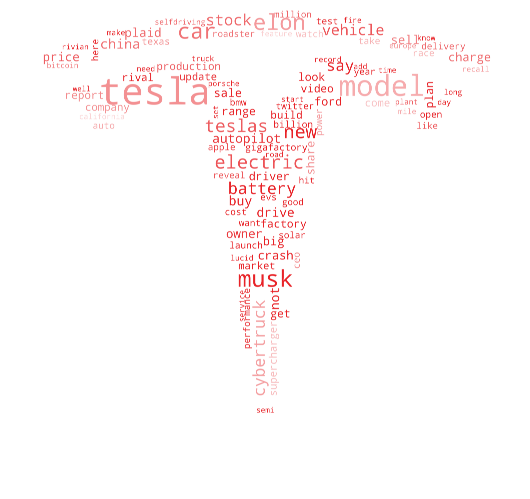

In [50]:
# 워드 클라우드 생성 함수 : Tesla News 들의 Word clound, Tesla logo 모양을 바탕으로 진행, 상위 100개만 표시함

mask = np.array(Image.open("C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/tesla_logo.jpg"))

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(raw_df['corpus'])

word_freq = np.sum(tfidf_matrix.toarray(), axis=0)
word_freq_dict = dict(zip(vectorizer.get_feature_names_out(), word_freq))

image_colors = ImageColorGenerator(mask)

# 워드 클라우드 생성
wordcloud = WordCloud(background_color="white",
                      mode="RGBA",
                      mask = mask,
                      width=800, 
                      height=800,
                      scale=2,
                      max_words=100).generate_from_frequencies(word_freq_dict)

image_colors = ImageColorGenerator(mask)

plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("wordcloud.png", dpi=300)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="antialiased")

In [52]:
# DTM을 데이터프레임으로 변환
vectorizer = TfidfVectorizer(vocabulary=list(set(all_keywords)))
tfidf_matrix = vectorizer.fit_transform(tsla_news_df['corpus'])

temp_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 각 행별로 TF-IDF 값이 높은 상위 7개의 단어를 선택
top_7_words = temp_df.apply(lambda row: row.nlargest(7).index.tolist(), axis=1)

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(top_7_words, columns=['Top_7_Words'])

# 날짜, 키워드 데이터 생성
temp_df = pd.DataFrame({
    'Date': tsla_df['Date'],
    'Keywords' : result_df['Top_7_Words']
})

temp_df.head()

,Date,Keywords
0,2020-01-01,"[allnew, map, israel, office, music, location,..."
1,2020-01-02,"[aqu, duizenden, goldsboro, coalicin, autovas,..."
2,2020-01-03,"[auburn, inde, handicap, dulle, bootleg, arala..."
3,2020-01-06,"[blindgngern, brandstofmotor, doore, allweathe..."
4,2020-01-07,"[fortschritt, english, expedition, bloccher, c..."


In [54]:
tsla_news_df['Keywords'] = temp_df['Keywords']
tsla_news_df.head()

,Date,Publisher,Description,News_Count,corpus,Keywords
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,tesla like debut music video supercharger mode...,"[allnew, map, israel, office, music, location,..."
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21,uit goldsboro man car des customer stock nye s...,"[aqu, duizenden, goldsboro, coalicin, autovas,..."
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27,dulle home ble man car gran stock fourth tempe...,"[auburn, inde, handicap, dulle, bootleg, arala..."
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45,die bicyclist probe business reim display cutt...,"[blindgngern, brandstofmotor, doore, allweathe..."
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27,gigafactora month offiziell har program swing ...,"[fortschritt, english, expedition, bloccher, c..."


#### 일단 키워드 7개를 잘랐는데, 그 이유는 5개는 감성 사전의 효과가 없기도 하고, 7개인 지점이 elbow point 처럼 식별되기 때문

### 1. 감성 분석 - 모델명 : McDonald

In [56]:
mcdonald_df = tsla_news_df.copy()
mcdonald_df.head()

,Date,Publisher,Description,News_Count,corpus,Keywords
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,tesla like debut music video supercharger mode...,"[allnew, map, israel, office, music, location,..."
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21,uit goldsboro man car des customer stock nye s...,"[aqu, duizenden, goldsboro, coalicin, autovas,..."
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27,dulle home ble man car gran stock fourth tempe...,"[auburn, inde, handicap, dulle, bootleg, arala..."
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45,die bicyclist probe business reim display cutt...,"[blindgngern, brandstofmotor, doore, allweathe..."
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27,gigafactora month offiziell har program swing ...,"[fortschritt, english, expedition, bloccher, c..."


In [57]:
### 감성분석 ###
from collections import defaultdict

# 감성분석 점수 및 키워드를 저장할 딕셔너리 초기화
description_sentiment_scores = defaultdict(float)
keywords_sentiment_scores = defaultdict(float)
keywords_dict = defaultdict(list)

# 감성 단어 개수를 저장할 딕셔너리 초기화
description_uncertainty_count = defaultdict(int)
description_litigious_count = defaultdict(int)
description_constraining_count = defaultdict(int)
description_superfluous_count = defaultdict(int)
description_weakmodal_count = defaultdict(int)
description_positive_count = defaultdict(int)
description_negative_count = defaultdict(int)

keywords_uncertainty_count = defaultdict(int)
keywords_litigious_count = defaultdict(int)
keywords_constraining_count = defaultdict(int)
keywords_superfluous_count = defaultdict(int)
keywords_weakmodal_count = defaultdict(int)
keywords_positive_count = defaultdict(int)
keywords_negative_count = defaultdict(int)

# Loughran-McDonald 사전 로드
sentiment_df = pd.read_csv('C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/LM-SA-2020.csv')

# 감성별 사전 초기화
uncertainty_dict = defaultdict(int)
litigious_dict = defaultdict(int)
constraining_dict = defaultdict(int)
superfluous_dict = defaultdict(int)
weakmodal_dict = defaultdict(int)
positive_dict = defaultdict(int)
negative_dict = defaultdict(int)

for _, row in sentiment_df.iterrows():
    word, sentiment = row['word'], row['sentiment']
    if sentiment == 'Uncertainty':
        uncertainty_dict[word] = 1
    elif sentiment == 'Litigious':
        litigious_dict[word] = 1
    elif sentiment == 'Constraining':
        constraining_dict[word] = 1
    elif sentiment == 'Superfluous':
        superfluous_dict[word] = 1
    elif sentiment == 'WeakModal':
        weakmodal_dict[word] = 1
    elif sentiment == 'Positive':
        positive_dict[word] = 1
    elif sentiment == 'Negative':
        negative_dict[word] = -1

In [63]:
# 감성 분석 함수
def sentiment_analysis(sentence, parms):
    counts = len(sentence.split())
    
    num, sentiment_dict = parms[0], parms[1]

    return sum(sentiment_dict[word] for word in sentence.split() if word in sentiment_dict)

# 감성 단어 개수를 세는 함수
def count_sentiment_words(sentences, sentiment_dict, count = 0):
    count += sum(1 for word in sentences.split() if word in sentiment_dict)
    
    return count

pd.DataFrame.iteritems = pd.DataFrame.items

for i, row in mcdonald_df.iterrows():
    date = row['Date']
    descriptions  = row['corpus']

    #감성분석 점수 계산 (감성 점수 합)
    description_sentiment_scores[date] = sum(sentiment_analysis(descriptions, sentiment) 
                                                   for sentiment in [[1, positive_dict], [2, negative_dict]])

    description_positive_count[date] = count_sentiment_words(descriptions, positive_dict)
    description_negative_count[date] = count_sentiment_words(descriptions, negative_dict)

# 감성분석 점수와 키워드를 데이터프레임에 추가
mcdonald_df['Description_Sentiment_Score'] = mcdonald_df['Date'].map(description_sentiment_scores)
mcdonald_df['Description_Positive_Count'] = mcdonald_df['Date'].map(description_positive_count)
mcdonald_df['Description_Negative_Count'] = mcdonald_df['Date'].map(description_negative_count)

mcdonald_df.head()

,Date,Publisher,Description,News_Count,corpus,Keywords,Description_Sentiment_Score,Description_Positive_Count,Description_Negative_Count
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,tesla like debut music video supercharger mode...,"[allnew, map, israel, office, music, location,...",1,2,1
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21,uit goldsboro man car des customer stock nye s...,"[aqu, duizenden, goldsboro, coalicin, autovas,...",-5,7,12
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27,dulle home ble man car gran stock fourth tempe...,"[auburn, inde, handicap, dulle, bootleg, arala...",-7,8,15
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45,die bicyclist probe business reim display cutt...,"[blindgngern, brandstofmotor, doore, allweathe...",-13,17,30
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27,gigafactora month offiziell har program swing ...,"[fortschritt, english, expedition, bloccher, c...",-3,6,9


#### mcdonald를 살펴보면 부정의 단어의 갯수가 긍정 단어의 비해 비율이 높음 - 해당 과정에 대한 전처리가 필요

#### 애매한게 갯수를 파악할 수는 있다, 그러나 점수화 시키는 기준이 애매함, 일단 키워드의 갯수도 기록

#### 해당 비율은 전처리를 하지 않고 부정 비율이 높음을 보여주고, 감성 사전의 특징을 언급해주면 좋을거같음

#### 그래서 다른 모델을 시도해봤다 ~ 이런느낌으로 PPT에 첨부

In [60]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 폰트 중 원하는 한글 폰트의 전체 경로 가져오기
font_path = fm.findfont(fm.FontProperties(fname='NanumGothic'))

# matplotlib의 rc(run command) 명령을 사용해 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

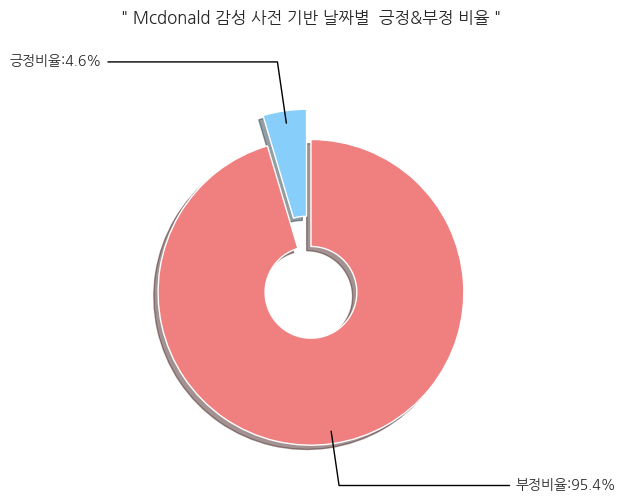

In [72]:
### Description 기준 감성 점수의 비율 ###

# 감성 점수가 0 이상의 경우 긍정
pos = len(mcdonald_df[mcdonald_df['Description_Sentiment_Score'] >= 0])/len(mcdonald_df)

# 감성 점수가 0 이하의 경우 부정
neg = len(mcdonald_df[mcdonald_df['Description_Sentiment_Score'] < -0])/len(mcdonald_df)

wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
explode = [0.1, 0.1]

# 긍정부정중립 비율 그래프
colors = [ 'lightskyblue','lightcoral']
labels = ['긍정', '부정']
sizes = [pos, neg]

fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, colors=colors, startangle=90, explode=explode, shadow=True, wedgeprops=wedgeprops)

ax.axis('equal')

# 각 부분을 가리키는 화살표와 비율 레이블 추가
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    xytext = (1.35*np.sign(x), 1.4*y)
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    labeling = str(labels[i])+"비율:"
    ax.annotate(labeling+'{:.1f}%'.format(sizes[i]*100),
                xy=(x, y), xytext=xytext,
                horizontalalignment=horizontalalignment,
                arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle))

plt.title('" Mcdonald 감성 사전 기반 날짜별  긍정&부정 비율 "', weight='bold', pad=50)

plt.show()

#### 2. Finbert_BertForSequenceClassification 감성 분석 모델

#### https://github.com/yya518/FinBERT 감성 모델 추출 : PPT 만들 때 해당 링크 설명 참조해서 첨부 바람

#### Setting

In [73]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

import transformers
transformers.__version__

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

12/05/2023 12:19:19 PM - From C:\Users\jjska\anaconda3\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [79]:
bfs_df = raw_df.copy()
bfs_df.head()

,Publisher,Date,Title,Description,corpus
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,tesla crash california autopilot kill
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,tesla cybertruck debut music make video
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,tesla like model allnew look
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,tesla office set israel
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,tesla map supercharger new update location


#### PPT 에는 생략해도 될거같은데, 해당 모델이 문장 길이의 제한이 있어서 일단 제목만 사용한다는 가정하에, TITLE로 감성 분석 실시

In [93]:
bfs_dataset = bfs_df['Description'].tolist()

KeyError: 'Description'

In [77]:
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)
bfs_results = []
bsf_erros = []

for index, corpus in enumerate(bfs_dataset):
    print(index)
    try:
        bfs_results.append(nlp(corpus))
    except:
        bsf_erros.append(index)
        
print(bsf_erros)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341


6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980


8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621


10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
1021

11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
1158

12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
1295

14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
1432

15523
15524
15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
1568

16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
1705

In [80]:
bfs_df['result'] = bfs_results

bfs_df['bfs_label'] = bfs_df['result'].apply(lambda x: x[0]['label'])
bfs_df['bfs_score'] = bfs_df['result'].apply(lambda x: x[0]['score'])

bfs_df.drop(columns=['result'], inplace = True)
bfs_df.head()

,Publisher,Date,Title,Description,corpus,bfs_label,bfs_score
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,tesla crash california autopilot kill,Neutral,0.944280
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,tesla cybertruck debut music make video,Neutral,0.999896
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,tesla like model allnew look,Neutral,0.997783
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,tesla office set israel,Neutral,0.999993
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,tesla map supercharger new update location,Neutral,0.999988


In [82]:
bfs_df['Date'] = pd.to_datetime(bfs_df['Date'])

In [84]:
# 우선, 데이터를 'Date'와 'label' 기준으로 그룹화하고, 'score'의 합계를 구합니다.
grouped = bfs_df.groupby(['Date', 'bfs_label'])['bfs_score'].sum().reset_index()

# 그런 다음, pivot_table 함수를 사용하여 'label' 값을 새로운 열로 전환하고, 해당 'score'값을 채웁니다.
pivot_df = grouped.pivot_table(values='bfs_score', index='Date', columns='bfs_label', fill_value=0).reset_index()

# 열 이름을 원하는 대로 변경할 수 있습니다.
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={'neutral': 'neutral_scores', 'positive': 'positive_scores', 'negative': 'negative_scores'})

pivot_df.head()  # 결과 확인

,Date,Negative,Neutral,Positive
0,2020-01-01,0.000000,3.997660,0.000000
1,2020-01-02,0.000000,19.726527,0.772285
2,2020-01-03,1.994734,21.683010,2.999998
3,2020-01-04,0.000000,4.719060,0.997491
4,2020-01-05,0.999609,13.213550,2.681623


In [88]:
pivot_df = pivot_df.sort_values(by=["Date"], ascending=[True]) 
bfs_df = pivot_df[pivot_df['Date'] <= '2022-12-31']
bfs_df

,Date,Negative,Neutral,Positive
0,2020-01-01,0.000000,3.997660,0.000000
1,2020-01-02,0.000000,19.726527,0.772285
2,2020-01-03,1.994734,21.683010,2.999998
3,2020-01-04,0.000000,4.719060,0.997491
4,2020-01-05,0.999609,13.213550,2.681623
...,...,...,...,...
1091,2022-12-27,3.944280,9.441516,0.000000
1092,2022-12-28,0.528762,12.540282,2.602829
1093,2022-12-29,4.574071,11.767893,1.997122
1094,2022-12-30,2.836195,10.962075,1.891300


In [89]:
# 날짜에서 요일을 추출 (월요일: 0, 일요일: 6)
bfs_df['weekday'] = bfs_df['Date'].dt.weekday

# 요일이 토요일(5), 일요일(6)인 경우 그 다음 월요일로 변경한 날짜를 'group_date'라는 새로운 컬럼에 저장
bfs_df['group_date'] = bfs_df.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)

# 'group_date' 컬럼의 이름을 'Date'로 변경
bfs_df.rename(columns={'group_date': 'new_date'}, inplace=True)
bfs_df.head()

,Date,Negative,Neutral,Positive,weekday,new_date
0,2020-01-01,0.000000,3.997660,0.000000,2,2020-01-01
1,2020-01-02,0.000000,19.726527,0.772285,3,2020-01-02
2,2020-01-03,1.994734,21.683010,2.999998,4,2020-01-03
3,2020-01-04,0.000000,4.719060,0.997491,5,2020-01-06
4,2020-01-05,0.999609,13.213550,2.681623,6,2020-01-06


In [90]:
bfs_df = bfs_df.groupby('new_date')['Negative', 'Neutral', 'Positive'].mean().reset_index()
bfs_df

,new_date,Negative,Neutral,Positive
0,2020-01-01,0.000000,3.997660,0.000000
1,2020-01-02,0.000000,19.726527,0.772285
2,2020-01-03,1.994734,21.683010,2.999998
3,2020-01-06,0.666535,11.250165,2.432849
4,2020-01-07,1.551042,23.577997,0.999993
...,...,...,...,...
779,2022-12-27,3.944280,9.441516,0.000000
780,2022-12-28,0.528762,12.540282,2.602829
781,2022-12-29,4.574071,11.767893,1.997122
782,2022-12-30,2.836195,10.962075,1.891300


In [91]:
bfs_df = bfs_df.drop(bfs_df.index[-1])
bfs_df

,new_date,Negative,Neutral,Positive
0,2020-01-01,0.000000,3.997660,0.000000
1,2020-01-02,0.000000,19.726527,0.772285
2,2020-01-03,1.994734,21.683010,2.999998
3,2020-01-06,0.666535,11.250165,2.432849
4,2020-01-07,1.551042,23.577997,0.999993
...,...,...,...,...
778,2022-12-26,1.984398,5.969481,0.000000
779,2022-12-27,3.944280,9.441516,0.000000
780,2022-12-28,0.528762,12.540282,2.602829
781,2022-12-29,4.574071,11.767893,1.997122


#### 3번 째, ProusAI/finbert

#### 출처 : https://songseungwon.tistory.com/124

In [95]:
from transformers import pipeline
sentiment_pipe = pipeline(model = 'ProsusAI/finbert')

In [96]:
paf_df = raw_df.copy()
paf_df.head()

,Publisher,Date,Title,Description,corpus
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,tesla crash california autopilot kill
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,tesla cybertruck debut music make video
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,tesla like model allnew look
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,tesla office set israel
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,tesla map supercharger new update location


In [97]:
paf_dataset = paf_df['Description'].tolist()

In [98]:
paf_results = []
paf_erros = []

for index, corpus in enumerate(paf_dataset):
    try:
        paf_results.append(sentiment_pipe(corpus))
    except:
        paf_erros.append(index)
        
print(paf_erros)

[]


In [99]:
paf_df['result'] = paf_results

paf_df['paf_label'] = paf_df['result'].apply(lambda x: x[0]['label'])
paf_df['paf_score'] = paf_df['result'].apply(lambda x: x[0]['score'])

paf_df.drop(columns=['result'], inplace = True)
paf_df.head()

,Publisher,Date,Title,Description,corpus,paf_label,paf_score
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,tesla crash california autopilot kill,negative,0.823367
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,tesla cybertruck debut music make video,neutral,0.916807
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,tesla like model allnew look,neutral,0.933812
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,tesla office set israel,neutral,0.898507
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,tesla map supercharger new update location,neutral,0.872902


In [100]:
paf_df['Date'] = pd.to_datetime(paf_df['Date'])

In [103]:
# 우선, 데이터를 'Date'와 'label' 기준으로 그룹화하고, 'score'의 합계를 구합니다.
grouped = paf_df.groupby(['Date', 'paf_label'])['paf_score'].sum().reset_index()

# 그런 다음, pivot_table 함수를 사용하여 'label' 값을 새로운 열로 전환하고, 해당 'score'값을 채웁니다.
pivot_df = grouped.pivot_table(values='paf_score', index='Date', columns='paf_label', fill_value=0).reset_index()

# 열 이름을 원하는 대로 변경할 수 있습니다.
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={'neutral': 'neutral_scores', 'positive': 'positive_scores', 'negative': 'negative_scores'})

pivot_df.head()  # 결과 확인

,Date,negative_scores,neutral_scores,positive_scores
0,2020-01-01,0.000000,3.622029,0.000000
1,2020-01-02,2.433325,14.463045,0.654019
2,2020-01-03,2.090888,16.970401,3.261286
3,2020-01-04,0.000000,5.161453,0.000000
4,2020-01-05,1.835299,11.127064,1.087341


In [104]:
pivot_df = pivot_df.sort_values(by=["Date"], ascending=[True]) 
paf_df = pivot_df[pivot_df['Date'] <= '2022-12-31']
paf_df

,Date,negative_scores,neutral_scores,positive_scores
0,2020-01-01,0.000000,3.622029,0.000000
1,2020-01-02,2.433325,14.463045,0.654019
2,2020-01-03,2.090888,16.970401,3.261286
3,2020-01-04,0.000000,5.161453,0.000000
4,2020-01-05,1.835299,11.127064,1.087341
...,...,...,...,...
1091,2022-12-27,5.188538,6.972080,0.000000
1092,2022-12-28,3.533733,11.365455,0.834644
1093,2022-12-29,5.326584,8.361750,2.103887
1094,2022-12-30,1.928616,9.161045,1.703432


In [105]:
# 날짜에서 요일을 추출 (월요일: 0, 일요일: 6)
paf_df['weekday'] = paf_df['Date'].dt.weekday

# 요일이 토요일(5), 일요일(6)인 경우 그 다음 월요일로 변경한 날짜를 'group_date'라는 새로운 컬럼에 저장
paf_df['group_date'] = paf_df.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)

# 'group_date' 컬럼의 이름을 'Date'로 변경
paf_df.rename(columns={'group_date': 'new_date'}, inplace=True)
paf_df.head()

,Date,negative_scores,neutral_scores,positive_scores,weekday,new_date
0,2020-01-01,0.000000,3.622029,0.000000,2,2020-01-01
1,2020-01-02,2.433325,14.463045,0.654019,3,2020-01-02
2,2020-01-03,2.090888,16.970401,3.261286,4,2020-01-03
3,2020-01-04,0.000000,5.161453,0.000000,5,2020-01-06
4,2020-01-05,1.835299,11.127064,1.087341,6,2020-01-06


In [107]:
paf_df = paf_df.groupby('new_date')['negative_scores', 'neutral_scores', 'positive_scores'].mean().reset_index()
paf_df

,new_date,negative_scores,neutral_scores,positive_scores
0,2020-01-01,0.000000,3.622029,0.000000
1,2020-01-02,2.433325,14.463045,0.654019
2,2020-01-03,2.090888,16.970401,3.261286
3,2020-01-06,0.611766,10.516358,1.132253
4,2020-01-07,0.967349,20.643528,0.547569
...,...,...,...,...
779,2022-12-27,5.188538,6.972080,0.000000
780,2022-12-28,3.533733,11.365455,0.834644
781,2022-12-29,5.326584,8.361750,2.103887
782,2022-12-30,1.928616,9.161045,1.703432


In [108]:
paf_df = paf_df.drop(paf_df.index[-1])
paf_df

,new_date,negative_scores,neutral_scores,positive_scores
0,2020-01-01,0.000000,3.622029,0.000000
1,2020-01-02,2.433325,14.463045,0.654019
2,2020-01-03,2.090888,16.970401,3.261286
3,2020-01-06,0.611766,10.516358,1.132253
4,2020-01-07,0.967349,20.643528,0.547569
...,...,...,...,...
778,2022-12-26,1.647488,5.123321,0.000000
779,2022-12-27,5.188538,6.972080,0.000000
780,2022-12-28,3.533733,11.365455,0.834644
781,2022-12-29,5.326584,8.361750,2.103887


#### 4. VADER를 활용한 감성 사전

#### 출처 : https://kopio.tistory.com/8#google_vignette

In [109]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...


In [116]:
vad_df = raw_df.copy()
vad_df.head()

,Publisher,Date,Title,Description,corpus
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,tesla crash california autopilot kill
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,tesla cybertruck debut music make video
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,tesla like model allnew look
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,tesla office set israel
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,tesla map supercharger new update location


In [111]:
vad_dataset = vad_df['Description'].tolist()

In [112]:
vad_results = []
vad_erros = []

for index, corpus in enumerate(vad_dataset):
    try:
        vad_results.append(sia.polarity_scores(corpus))
    except:
        vad_erros.append(index)
        
print(vad_erros)

[]


In [119]:
vad_results[:5]

[{'neg': 0.419, 'neu': 0.581, 'pos': 0.0, 'compound': -0.802},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'compound': 0.3612},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

In [118]:
vad_df['result'] = vad_results

vad_df['vad_neg'] = vad_df['result'].apply(lambda x: x['neg'])
vad_df['vad_neu'] = vad_df['result'].apply(lambda x: x['neu'])
vad_df['vad_pos'] = vad_df['result'].apply(lambda x: x['pos'])
vad_df['vad_compound'] = vad_df['result'].apply(lambda x: x['compound'])

vad_df.drop(columns=['result'], inplace = True)
vad_df.head()

,Publisher,Date,Title,Description,corpus,vad_neg,vad_neu,vad_pos,vad_compound
0,The Guardian,2020.01.02,Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...,tesla crash california autopilot kill,0.419,0.581,0.000,-0.8020
1,CarBuzz,2020.01.01,Tesla Cybertruck Makes Music Video Debut -,Tesla Cybertruck Makes Music Video Debut,tesla cybertruck debut music make video,0.000,1.000,0.000,0.0000
2,CarBuzz,2020.01.01,All-New Tesla Model S Could Look Like This -,AllNew Tesla Model S Could Look Like This,tesla like model allnew look,0.000,0.706,0.294,0.3612
3,Globes,2020.01.01,Tesla setting up Israel R&D office - -,Tesla setting up Israel RD office,tesla office set israel,0.000,1.000,0.000,0.0000
4,Electrek,2020.01.01,Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...,tesla map supercharger new update location,0.000,1.000,0.000,0.0000


In [120]:
vad_df['Date'] = pd.to_datetime(vad_df['Date'])

In [121]:
grouped = vad_df.groupby('Date')['vad_neg', 'vad_neu', 'vad_pos', 'vad_compound'].mean().reset_index()
grouped

,Date,vad_neg,vad_neu,vad_pos,vad_compound
0,2020-01-01,0.000000,0.926500,0.073500,0.090300
1,2020-01-02,0.102095,0.887905,0.010000,-0.130795
2,2020-01-03,0.020407,0.933519,0.046074,0.054081
3,2020-01-04,0.042000,0.904333,0.053667,0.004450
4,2020-01-05,0.053778,0.819000,0.071667,0.031678
...,...,...,...,...,...
1104,2023-08-09,0.000000,1.000000,0.000000,0.000000
1105,2023-08-31,0.000000,0.755000,0.245000,0.381800
1106,2023-11-16,0.000000,1.000000,0.000000,0.000000
1107,2023-11-21,0.000000,1.000000,0.000000,0.000000


In [123]:
grouped = grouped.sort_values(by=["Date"], ascending=[True]) 
grouped = grouped[grouped['Date'] <= '2022-12-31']
grouped

,Date,vad_neg,vad_neu,vad_pos,vad_compound
0,2020-01-01,0.000000,0.926500,0.073500,0.090300
1,2020-01-02,0.102095,0.887905,0.010000,-0.130795
2,2020-01-03,0.020407,0.933519,0.046074,0.054081
3,2020-01-04,0.042000,0.904333,0.053667,0.004450
4,2020-01-05,0.053778,0.819000,0.071667,0.031678
...,...,...,...,...,...
1091,2022-12-27,0.098500,0.834643,0.066857,-0.102943
1092,2022-12-28,0.066722,0.872833,0.060500,-0.032828
1093,2022-12-29,0.093050,0.854450,0.052450,-0.041520
1094,2022-12-30,0.073125,0.856437,0.070438,0.001688


In [124]:
# 날짜에서 요일을 추출 (월요일: 0, 일요일: 6)
grouped['weekday'] = grouped['Date'].dt.weekday

# 요일이 토요일(5), 일요일(6)인 경우 그 다음 월요일로 변경한 날짜를 'group_date'라는 새로운 컬럼에 저장
grouped['group_date'] = grouped.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)

# 'group_date' 컬럼의 이름을 'Date'로 변경
grouped.rename(columns={'group_date': 'new_date'}, inplace=True)
grouped.head()

,Date,vad_neg,vad_neu,vad_pos,vad_compound,weekday,new_date
0,2020-01-01,0.000000,0.926500,0.073500,0.090300,2,2020-01-01
1,2020-01-02,0.102095,0.887905,0.010000,-0.130795,3,2020-01-02
2,2020-01-03,0.020407,0.933519,0.046074,0.054081,4,2020-01-03
3,2020-01-04,0.042000,0.904333,0.053667,0.004450,5,2020-01-06
4,2020-01-05,0.053778,0.819000,0.071667,0.031678,6,2020-01-06


In [125]:
grouped

,Date,vad_neg,vad_neu,vad_pos,vad_compound,weekday,new_date
0,2020-01-01,0.000000,0.926500,0.073500,0.090300,2,2020-01-01
1,2020-01-02,0.102095,0.887905,0.010000,-0.130795,3,2020-01-02
2,2020-01-03,0.020407,0.933519,0.046074,0.054081,4,2020-01-03
3,2020-01-04,0.042000,0.904333,0.053667,0.004450,5,2020-01-06
4,2020-01-05,0.053778,0.819000,0.071667,0.031678,6,2020-01-06
...,...,...,...,...,...,...,...
1091,2022-12-27,0.098500,0.834643,0.066857,-0.102943,1,2022-12-27
1092,2022-12-28,0.066722,0.872833,0.060500,-0.032828,2,2022-12-28
1093,2022-12-29,0.093050,0.854450,0.052450,-0.041520,3,2022-12-29
1094,2022-12-30,0.073125,0.856437,0.070438,0.001688,4,2022-12-30


In [128]:
vad_df = grouped.groupby('new_date')['vad_neg', 'vad_neu', 'vad_pos', 'vad_compound'].mean().reset_index()
vad_df

,new_date,vad_neg,vad_neu,vad_pos,vad_compound
0,2020-01-01,0.000000,0.926500,0.073500,0.090300
1,2020-01-02,0.102095,0.887905,0.010000,-0.130795
2,2020-01-03,0.020407,0.933519,0.046074,0.054081
3,2020-01-06,0.053672,0.856730,0.071079,0.022152
4,2020-01-07,0.015778,0.862704,0.047481,0.032322
...,...,...,...,...,...
779,2022-12-27,0.098500,0.834643,0.066857,-0.102943
780,2022-12-28,0.066722,0.872833,0.060500,-0.032828
781,2022-12-29,0.093050,0.854450,0.052450,-0.041520
782,2022-12-30,0.073125,0.856437,0.070438,0.001688


In [129]:
vad_df = vad_df.drop(vad_df.index[-1])
vad_df

,new_date,vad_neg,vad_neu,vad_pos,vad_compound
0,2020-01-01,0.000000,0.926500,0.073500,0.090300
1,2020-01-02,0.102095,0.887905,0.010000,-0.130795
2,2020-01-03,0.020407,0.933519,0.046074,0.054081
3,2020-01-06,0.053672,0.856730,0.071079,0.022152
4,2020-01-07,0.015778,0.862704,0.047481,0.032322
...,...,...,...,...,...
778,2022-12-26,0.054663,0.911952,0.033385,-0.051709
779,2022-12-27,0.098500,0.834643,0.066857,-0.102943
780,2022-12-28,0.066722,0.872833,0.060500,-0.032828
781,2022-12-29,0.093050,0.854450,0.052450,-0.041520


#### 여기까지가 일단 감성 분석 과정 코드, 이제부터 결과값들

In [133]:
# 첫 번 째 감성 분석 모델
mcdonald_df

,Date,Publisher,Description,News_Count,corpus,Keywords,Description_Sentiment_Score,Description_Positive_Count,Description_Negative_Count
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,tesla like debut music video supercharger mode...,"[allnew, map, israel, office, music, location,...",1,2,1
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21,uit goldsboro man car des customer stock nye s...,"[aqu, duizenden, goldsboro, coalicin, autovas,...",-5,7,12
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27,dulle home ble man car gran stock fourth tempe...,"[auburn, inde, handicap, dulle, bootleg, arala...",-7,8,15
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45,die bicyclist probe business reim display cutt...,"[blindgngern, brandstofmotor, doore, allweathe...",-13,17,30
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27,gigafactora month offiziell har program swing ...,"[fortschritt, english, expedition, bloccher, c...",-3,6,9
...,...,...,...,...,...,...,...,...,...
778,2022-12-26,"[Car, Drive, Fox, Motor16, Motley, Washington,...",Elon Musks Twitter obsession isnt the core rea...,24,wheel long habit car freeze ban bet worry tank...,"[datametrex, spanishspeake, batteripakke, auqu...",-20,5,25
779,2022-12-27,"[TIME, Inverse, Tampa, Telex, ADAC, Lrytas.lt,...",Why Tesla Stocks Dropped So Much in 2022 Tesla...,14,sugujo see month jab car bet advertise output ...,"[tampa, datametrex, spanishspeake, batteripakk...",-8,7,15
780,2022-12-28,"[Sky, Interview, Du, Yahoo, News, E24, USA, Fi...",Bus und Bahn in Oberhavel Weniger Zulassungen ...,18,staff market month continue low long right str...,"[datametrex, spanishspeake, batteripakke, auqu...",-12,5,17
781,2022-12-29,"[Torque, Drive, Yahoo, Electrek, News, Mashabl...",Musk tells Tesla workers not to be bothered by...,20,market bother lease treatment weave slump add ...,"[datametrex, spanishspeake, batteripakke, auqu...",-15,4,19


In [134]:
# 두번째 감성 분석 모델
bfs_df

,new_date,Negative,Neutral,Positive
0,2020-01-01,0.000000,3.997660,0.000000
1,2020-01-02,0.000000,19.726527,0.772285
2,2020-01-03,1.994734,21.683010,2.999998
3,2020-01-06,0.666535,11.250165,2.432849
4,2020-01-07,1.551042,23.577997,0.999993
...,...,...,...,...
778,2022-12-26,1.984398,5.969481,0.000000
779,2022-12-27,3.944280,9.441516,0.000000
780,2022-12-28,0.528762,12.540282,2.602829
781,2022-12-29,4.574071,11.767893,1.997122


In [135]:
# 세번째 감성분석 모델
paf_df

,new_date,negative_scores,neutral_scores,positive_scores
0,2020-01-01,0.000000,3.622029,0.000000
1,2020-01-02,2.433325,14.463045,0.654019
2,2020-01-03,2.090888,16.970401,3.261286
3,2020-01-06,0.611766,10.516358,1.132253
4,2020-01-07,0.967349,20.643528,0.547569
...,...,...,...,...
778,2022-12-26,1.647488,5.123321,0.000000
779,2022-12-27,5.188538,6.972080,0.000000
780,2022-12-28,3.533733,11.365455,0.834644
781,2022-12-29,5.326584,8.361750,2.103887


In [136]:
# 네번째 감성분석 모델
vad_df

,new_date,vad_neg,vad_neu,vad_pos,vad_compound
0,2020-01-01,0.000000,0.926500,0.073500,0.090300
1,2020-01-02,0.102095,0.887905,0.010000,-0.130795
2,2020-01-03,0.020407,0.933519,0.046074,0.054081
3,2020-01-06,0.053672,0.856730,0.071079,0.022152
4,2020-01-07,0.015778,0.862704,0.047481,0.032322
...,...,...,...,...,...
778,2022-12-26,0.054663,0.911952,0.033385,-0.051709
779,2022-12-27,0.098500,0.834643,0.066857,-0.102943
780,2022-12-28,0.066722,0.872833,0.060500,-0.032828
781,2022-12-29,0.093050,0.854450,0.052450,-0.041520


In [137]:
# 하나의 데이터셋에 합치기
tsla_news_df

,Date,Publisher,Description,News_Count,corpus,Keywords
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,tesla like debut music video supercharger mode...,"[allnew, map, israel, office, music, location,..."
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21,uit goldsboro man car des customer stock nye s...,"[aqu, duizenden, goldsboro, coalicin, autovas,..."
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27,dulle home ble man car gran stock fourth tempe...,"[auburn, inde, handicap, dulle, bootleg, arala..."
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45,die bicyclist probe business reim display cutt...,"[blindgngern, brandstofmotor, doore, allweathe..."
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27,gigafactora month offiziell har program swing ...,"[fortschritt, english, expedition, bloccher, c..."
...,...,...,...,...,...,...
778,2022-12-26,"[Car, Drive, Fox, Motor16, Motley, Washington,...",Elon Musks Twitter obsession isnt the core rea...,24,wheel long habit car freeze ban bet worry tank...,"[datametrex, spanishspeake, batteripakke, auqu..."
779,2022-12-27,"[TIME, Inverse, Tampa, Telex, ADAC, Lrytas.lt,...",Why Tesla Stocks Dropped So Much in 2022 Tesla...,14,sugujo see month jab car bet advertise output ...,"[tampa, datametrex, spanishspeake, batteripakk..."
780,2022-12-28,"[Sky, Interview, Du, Yahoo, News, E24, USA, Fi...",Bus und Bahn in Oberhavel Weniger Zulassungen ...,18,staff market month continue low long right str...,"[datametrex, spanishspeake, batteripakke, auqu..."
781,2022-12-29,"[Torque, Drive, Yahoo, Electrek, News, Mashabl...",Musk tells Tesla workers not to be bothered by...,20,market bother lease treatment weave slump add ...,"[datametrex, spanishspeake, batteripakke, auqu..."


In [138]:
tsla_news_df['mcdonald_scores'] = mcdonald_df['Description_Sentiment_Score']
tsla_news_df['mcdonald_pos_cnt'] = mcdonald_df['Description_Positive_Count']
tsla_news_df['mcdonald_neg_cnt'] = mcdonald_df['Description_Negative_Count']

tsla_news_df['bfs_neg'] = bfs_df['Negative']
tsla_news_df['bfs_neu'] = bfs_df['Neutral']
tsla_news_df['bfs_pos'] = bfs_df['Positive']

tsla_news_df['paf_neg'] = paf_df['negative_scores']
tsla_news_df['paf_neu'] = paf_df['neutral_scores']
tsla_news_df['paf_pos'] = paf_df['positive_scores']

tsla_news_df['vad_neg'] = vad_df['vad_neg']
tsla_news_df['vad_neu'] = vad_df['vad_neu']
tsla_news_df['vad_pos'] = vad_df['vad_pos']
tsla_news_df['vad_compound'] = vad_df['vad_compound']

tsla_news_df.head()

,Date,Publisher,Description,News_Count,corpus,Keywords,mcdonald_scores,mcdonald_pos_cnt,mcdonald_neg_cnt,bfs_neg,bfs_neu,bfs_pos,paf_neg,paf_neu,paf_pos,vad_neg,vad_neu,vad_pos,vad_compound
0,2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,tesla like debut music video supercharger mode...,"[allnew, map, israel, office, music, location,...",1,2,1,0.000000,3.997660,0.000000,0.000000,3.622029,0.000000,0.000000,0.926500,0.073500,0.090300
1,2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21,uit goldsboro man car des customer stock nye s...,"[aqu, duizenden, goldsboro, coalicin, autovas,...",-5,7,12,0.000000,19.726527,0.772285,2.433325,14.463045,0.654019,0.102095,0.887905,0.010000,-0.130795
2,2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27,dulle home ble man car gran stock fourth tempe...,"[auburn, inde, handicap, dulle, bootleg, arala...",-7,8,15,1.994734,21.683010,2.999998,2.090888,16.970401,3.261286,0.020407,0.933519,0.046074,0.054081
3,2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45,die bicyclist probe business reim display cutt...,"[blindgngern, brandstofmotor, doore, allweathe...",-13,17,30,0.666535,11.250165,2.432849,0.611766,10.516358,1.132253,0.053672,0.856730,0.071079,0.022152
4,2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27,gigafactora month offiziell har program swing ...,"[fortschritt, english, expedition, bloccher, c...",-3,6,9,1.551042,23.577997,0.999993,0.967349,20.643528,0.547569,0.015778,0.862704,0.047481,0.032322


In [141]:
tsla_news_df.columns

Index(['Date', 'Publisher', 'Description', 'News_Count', 'corpus', 'Keywords',
       'mcdonald_scores', 'mcdonald_pos_cnt', 'mcdonald_neg_cnt', 'bfs_neg',
       'bfs_neu', 'bfs_pos', 'paf_neg', 'paf_neu', 'paf_pos', 'vad_neg',
       'vad_neu', 'vad_pos', 'vad_compound'],
      dtype='object')

In [142]:
# 'Date' 열을 인덱스로 설정
tsla_news_df.set_index('Date', inplace=True)
tsla_news_df.head()

tsla_news_df.to_csv('C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Output/text_analysis_completed_data.csv')

In [143]:
tsla_news_df.head()

,Publisher,Description,News_Count,corpus,Keywords,mcdonald_scores,mcdonald_pos_cnt,mcdonald_neg_cnt,bfs_neg,bfs_neu,bfs_pos,paf_neg,paf_neu,paf_pos,vad_neg,vad_neu,vad_pos,vad_compound
Date,,,,,,,,,,,,,,,,,,
2020-01-01,"[Electrek, Globes, CarBuzz]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,tesla like debut music video supercharger mode...,"[allnew, map, israel, office, music, location,...",1,2,1,0.000000,3.997660,0.000000,0.000000,3.622029,0.000000,0.000000,0.926500,0.073500,0.090300
2020-01-02,"[AutoSpies.com, DRIVE, Trends, Exterior, News,...",Tesla may have been on Autopilot in California...,21,uit goldsboro man car des customer stock nye s...,"[aqu, duizenden, goldsboro, coalicin, autovas,...",-5,7,12,0.000000,19.726527,0.772285,2.433325,14.463045,0.654019,0.102095,0.887905,0.010000,-0.130795
2020-01-03,"[syracuse.com, Fossbytes, IndyStar, Bloomberg,...",Tesla to provide movies online games in its ca...,27,dulle home ble man car gran stock fourth tempe...,"[auburn, inde, handicap, dulle, bootleg, arala...",-7,8,15,1.994734,21.683010,2.999998,2.090888,16.970401,3.261286,0.020407,0.933519,0.046074,0.054081
2020-01-06,"[Automobile, AutoWeek, Torque, Bloomberg, Fox,...",I70 crash one of 3 raising questions about Tes...,45,die bicyclist probe business reim display cutt...,"[blindgngern, brandstofmotor, doore, allweathe...",-13,17,30,0.666535,11.250165,2.432849,0.611766,10.516358,1.132253,0.053672,0.856730,0.071079,0.022152
2020-01-07,"[electrive.net, Fossbytes, Yahoo, Indonesia, M...",China could be the swing factor for Teslas sto...,27,gigafactora month offiziell har program swing ...,"[fortschritt, english, expedition, bloccher, c...",-3,6,9,1.551042,23.577997,0.999993,0.967349,20.643528,0.547569,0.015778,0.862704,0.047481,0.032322
